# Exercise 2 | TKO_7092 Evaluation of Machine Learning Methods 2025
## deadline: 12.2.2025 - 23:59

Regarding any questions about this exercise, please contact course assistant Jonne Pohjankukka (jjepoh@utu.fi)

********************************************

Student name: Saara Mäkelä

Student number: 2203834

Student email: sahanm@utu.fi

********************************************

## Water permeability prediction in forestry <br>

In this task, the client wants you to estimate the spatial prediction performance of K-nearest neighbor regression model with K=7 (7NN), using spatial leave-one-out cross-validation (i.e. SKCV, with number of folds == number of data points). The client wants you to use the C-index as the performance measure.  

In other words, the client wants you to answer the question: "What happens to the prediction performance of water permeability using 7-nearest neighbor regression model, when the geographical distance between known data and unknown data increases?".

In this task, you have three data files available (with 1691 data points): 

- input.csv, contains the 75 predictor features. 
- output.csv, contains the water permebility values. 
- coordinates.csv, contains the corresponding geographical coordinate locations of the data points. The unit of the coordinates is metre, and you can use Euclidean distance to calculate distances between the coordinate points. 

Implement the following tasks to complete this exercise:

********************************************

#### 1. Z-score standardize the predictor features (input.csv). 

#### 2. Perform spatial leave-one-out cross-validation with 7NN model for the provided data set (refer to the lectures 3.1.3 and 3.1.4 in 'Evaluating spatial models with spatial cross-validation' for help). Estimate the water permeability prediction performance (using 7NN model and C-index) with the following distance parameter values: d = 0, 20, 40, ..., 300 (that is, 20 meter intervals from 0m to 300m). 

#### 3. When you have calculated the C-index performance measure for each value of d, visualize the results with the C-index (y-axis) as a function of d (x-axis).

********************************************

Your .ipynb-file must include the following: 

- Your own implementation of the spatial leave-one-out cross-validation for the current task. You can use third-party libraries (e.g. Scikit-learn) if you want for implementing e.g. the 7-nearest neighbor. Also, try to follow good programming practices and add comments to relevant parts of your code explaining what you are doing and why.


- Plot of the graph C-index vs. distance parameter value. 


<br><br><br>
-- START IMPLEMENTING YOUR EXERCISE AFTER THIS LINE --
<br><br><br>

### Import necessary libraries

In [2]:
# In this cell, import all the libraries that you need. For example: 
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

### Read in the datasets

In [3]:
# In this cell, read the files input.csv, output.csv and coordinates.csv.
# Print out the dataset dimesions (i.e. number of rows and columns).
input_features = pd.read_csv('input.csv', header=None)
output_permeability = pd.read_csv('output.csv', header=None)
coordinates = pd.read_csv('coordinates.csv', header=None)
print('Input data:', input_features.shape)
print('output data:', output_permeability.shape)
print('coordinates:', coordinates.shape)

Input data: (1691, 75)
output data: (1691, 1)
coordinates: (1691, 2)


### Standardization of the predictor features (input.csv)

<font color='violet'>Example from [flexiple](https://flexiple.com/python/z-score-python) </font>

In [4]:
# Standardize the predictor features (input.csv) by removing the mean and scaling to unit variance. 
# In other words, z-score the predictor features. You are allowed to use third-party libraries for doing this. 
z_score = stats.zscore(input_features.values)
z_score_input_data = pd.DataFrame(z_score)

### Functions and analysis code

In [8]:
# Include here all the functions and other relevant code that you need in order to implement the task.

# Note! Utilize the following two functions in your implementation:

### Function for calculating C-index ###
# y: array containing true label values.
# yp: array containing the predicted label values.
def cindex(y, yp):
    n = 0
    h_num = 0 
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt): 
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt): 
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n


### Function for calculating the pairwise spatial distances between the data points ###
# The function will return a n-by-n matrix of Euclidean distances. For example, the
# distance_matrix element at indices i,j will contain the spatial distance between 
# data point i and j. Note that the element value is 0 always when i==j.
# coordinate_array: n-by-2 array containing the coordinates of the exercise data points.
def cdists(coordinate_array):
    number_of_observations = coordinate_array.shape[0]
    distance_matrix = np.zeros((number_of_observations, number_of_observations))
    for i in range(0, number_of_observations):
        distance_matrix[i, :] = np.sqrt(np.sum((coordinate_array - coordinate_array[i])**2, axis=1))
    return distance_matrix

### Function for spatial leave-one-out cross-validation ###
def SKCV(X, y, coords, distances):
    """Perform spatial leave-one-out cross-validation with 7NN for given distance thresholds.
    X: the features
    y: the actual permeability values
    coords: the coordinates as numpy
    distances: array list of the distances
    """
    c_index_results = []
    distance_matrix = cdists(coords)
    X_reset = X.reset_index(drop=True)
    y_reset = y.reset_index(drop=True)
    knn = KNeighborsRegressor(n_neighbors=7)
    for d in distances:
        y_true, y_pred = [], []
        for i in range(len(X_reset)):
            dists = distance_matrix[i]
            # only neighbors within distance d
            neighbors_idx = np.where((dists > d))[0] # corrected 
            if len(neighbors_idx) < 7:
                continue  # skip if not enough neighbors within distance
            knn.fit(X_reset.iloc[neighbors_idx, :], y_reset.iloc[neighbors_idx])
            y_true.append(y_reset.iloc[i])
            y_pred.append(knn.predict(X_reset.iloc[[i], :])[0])
        if len(y_true) > 1:
            c_index_results.append(cindex(np.array(y_true), np.array(y_pred)))
        else:
            c_index_results.append(None)  # No valid predictions
    return c_index_results

### Results for spatial leave-one-out cross-validation with 7-nearest neighbor regression model

In [9]:
# In this cell, run your script for the Spatial leave-One-Out cross-validation 
# with 7-nearest neighbor regression model and visualize the results as 
# requested in the task assignment.
distance_values = np.arange(0, 301, 20)
c_index_results = SKCV(z_score_input_data, output_permeability, coordinates.values, distance_values)

<font color='violet'>SKCV() takes a long time to run but it is to be expected. </font>

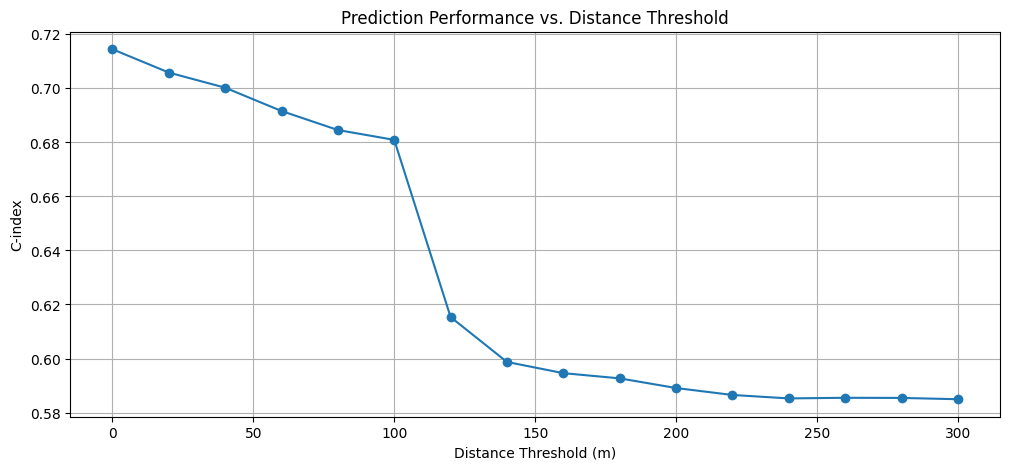

In [10]:
# I decided to do the visualization in a different cell as it is quite fast and the spatial_loocv isn't
plt.figure(figsize=(12,5))
plt.plot(distance_values, c_index_results, marker="o", linestyle="-")
plt.xlabel("Distance Threshold (m)")
plt.ylabel("C-index")
plt.title("Prediction Performance vs. Distance Threshold")
plt.grid()
plt.show()

## Analysis of the results

### In this cell, you need to answer the client's questions:


1. What happens to the 7NN performance as the prediction distance increases?


2. Do you think the results behave as was somewhat expected? Do they make sense, why?


3. If we require that the 7NN must have at least C-index performance of 0.68, then up to what distance should we trust the 7NN predictions, based on the results?

<font color='violet'>1. The 7NN performance gets notably worse as the prediction distance increases. </font>

<font color='violet'>2. I think the results do behave as was somewhat expected. The first law of geography states that nearer things are more related to each other than distant things. ([source](https://towardsdatascience.com/spatial-cross-validation-using-scikit-learn-74cb8ffe0ab9/)) Therefore when the distance grows, the things are less related to each other and the prediction gets much worse. (Now that the code is correct) we can see from the plot the clear difference between c-index when increasing the distance. </font>

<font color='violet'>3. Based on the results if we want to have at least c-index performance of 0.68 we can trust the distance up to 100mm. After that the c-index drops a lot. </font>